In [97]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

fft = np.fft.fft2
ifft = np.fft.ifft2



#filename = "/Users/mhughes/google_drive/codedungeon/sun_selector/data/thm_files/set_10/OR_SUVI-L1b-Fe195_G16_s20170911037044_e20170911037054_c20170911037188.fits"
filename = "/Users/mhughes/Desktop/noisy.fits"
outfile = "/Users/mhughes/Desktop/gated.fits"
image_file = fits.open(filename)
data = image_file[0].data
data = np.power(data, 0.25)
data[np.isnan(data)] = 0
data[np.isinf(data)] = 0

In [98]:
# define grid
xstart, xend, xstep = xwidth*2, data.shape[0] - (xwidth*2), int(xwidth/2)
ystart, yend, ystep = ywidth*2, data.shape[1] - (ywidth*2), int(ywidth/2)
x_ = np.arange(xstart, xend, xstep)
y_ = np.arange(ystart, yend, ystep)

coords = []
for x in x_:
    for y in y_:
        coords.append((x,y))

image_sections = []
imbar_sections = []

In [99]:
NX, NY = 2*xwidth+1, 2*ywidth+1
hanning_window_2D = lambda x, y : np.power(np.sin((x + 0.5)*np.pi / NX), 2.0) * np.power(np.sin((y + 0.5) * np.pi / NY), 2.0)

hanning = np.zeros((NX, NY))
for x in range(hanning.shape[0]):
    for y in range(hanning.shape[1]):
        hanning[x,y] = hanning_window_2D(x,y)

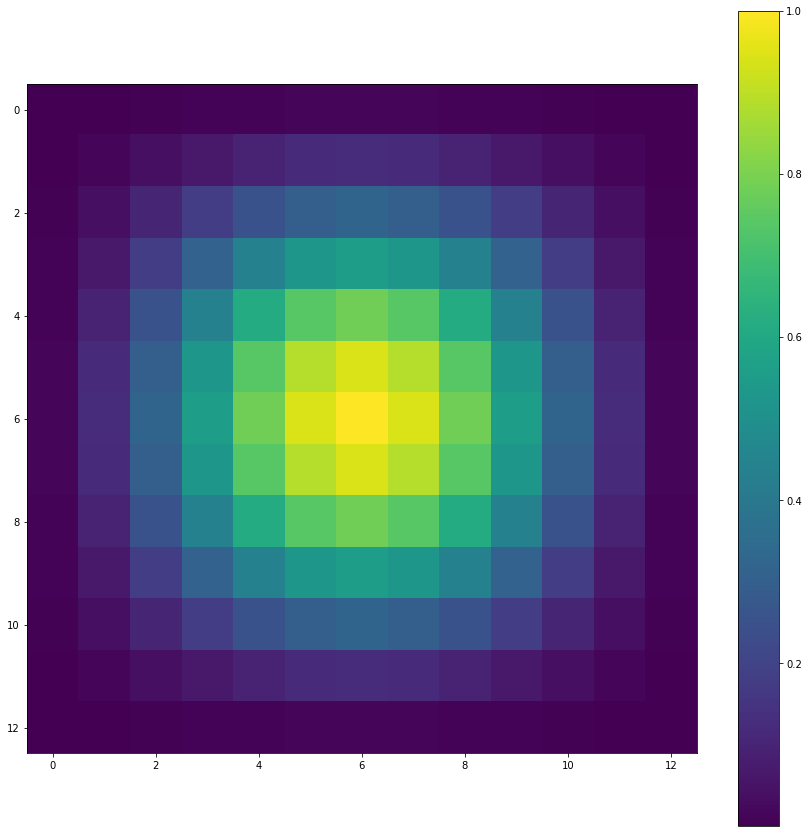

In [100]:
plt.figure(figsize=(15,15))
plt.imshow(hanning)
plt.colorbar()
plt.show()

In [101]:
print("image section retrieved")
for coord in coords:
    x, y = coord
    image_section = data[x-xwidth : x+xwidth + 1,
                          y-ywidth : y+ywidth + 1].copy()
    #image_section = signal.convolve(image_section, hanning, mode='same')
    image_section *= hanning
    image_sections.append(image_section)#, t-twidth//2])
    imbar_sections.append(np.sum(np.sqrt(image_section)))

image section retrieved


In [102]:
i = 100000
x, y = coords[i]
print(x,y)

726 846


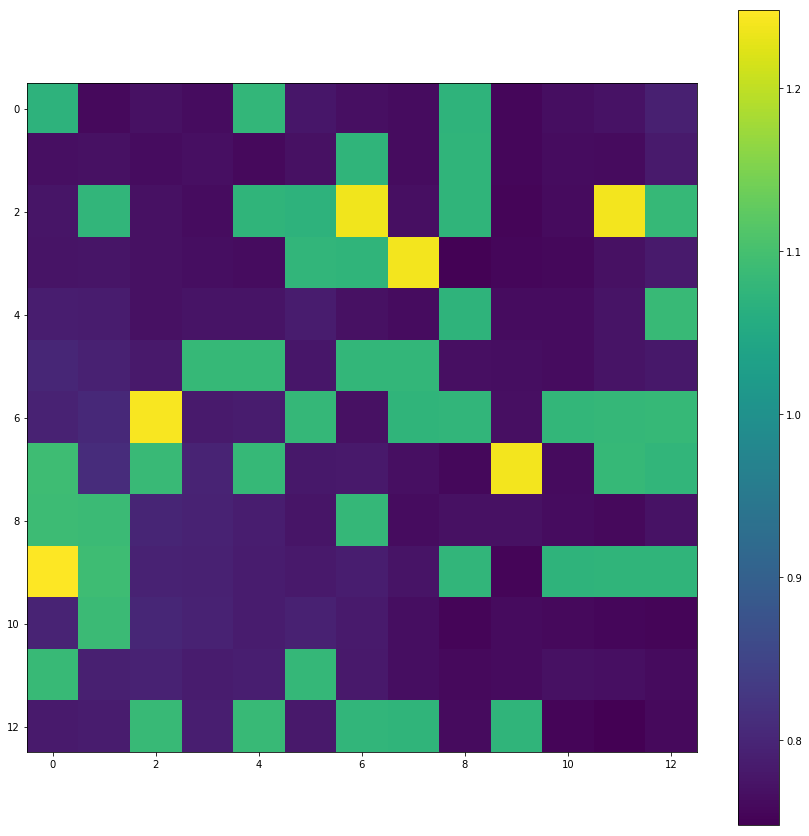

In [103]:
plt.figure(figsize=(15,15))
plt.imshow(data[x-xwidth : x+xwidth + 1, y-ywidth : y+ywidth + 1])
plt.colorbar()
plt.show()

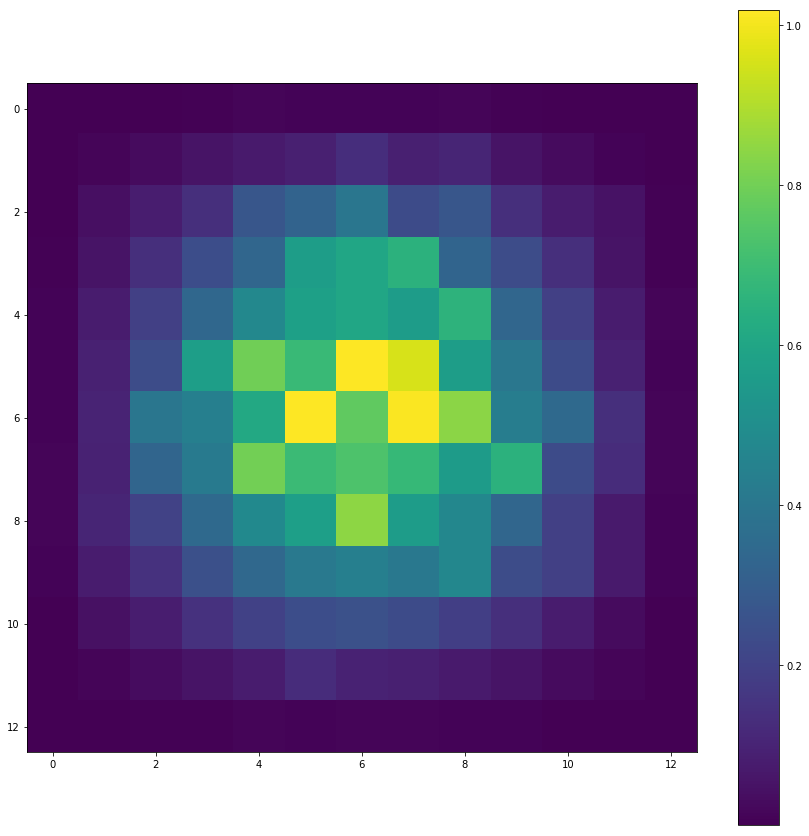

In [104]:
plt.figure(figsize=(15,15))
plt.imshow(image_sections[i])
plt.colorbar()
plt.show()

In [105]:
image_fourier_sections = []
image_fourier_sections_magnitude = []
for section in image_sections:
    #image_fourier = np.fft.fftshift(fft(section))
    image_fourier = fft(section)
    image_fourier_sections.append(image_fourier)
    #image_fourier_sections_magnitude.append(np.log(np.abs((image_fourier))**2))
    image_fourier_sections_magnitude.append(np.log(np.power(np.abs(image_fourier), 2.0)))

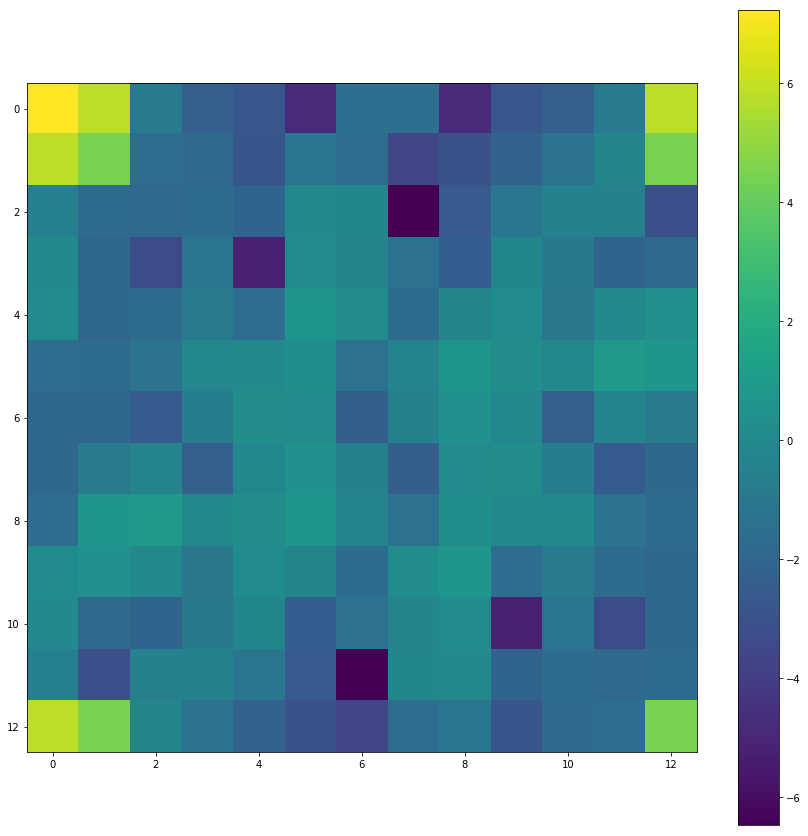

In [106]:
plt.figure(figsize=(15,15))
plt.imshow(image_fourier_sections_magnitude[i])#, vmax=0.001)
plt.colorbar()
plt.show()

In [107]:
imbar_sections[3]

51.84621

In [109]:
ims = [image_fourier_sections_magnitude[i] / imbar_sections[i] for i in range(len(image_sections))]
ims = np.dstack(ims)
beta_approx  = np.median(ims, axis=2)

/Users/mhughes/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


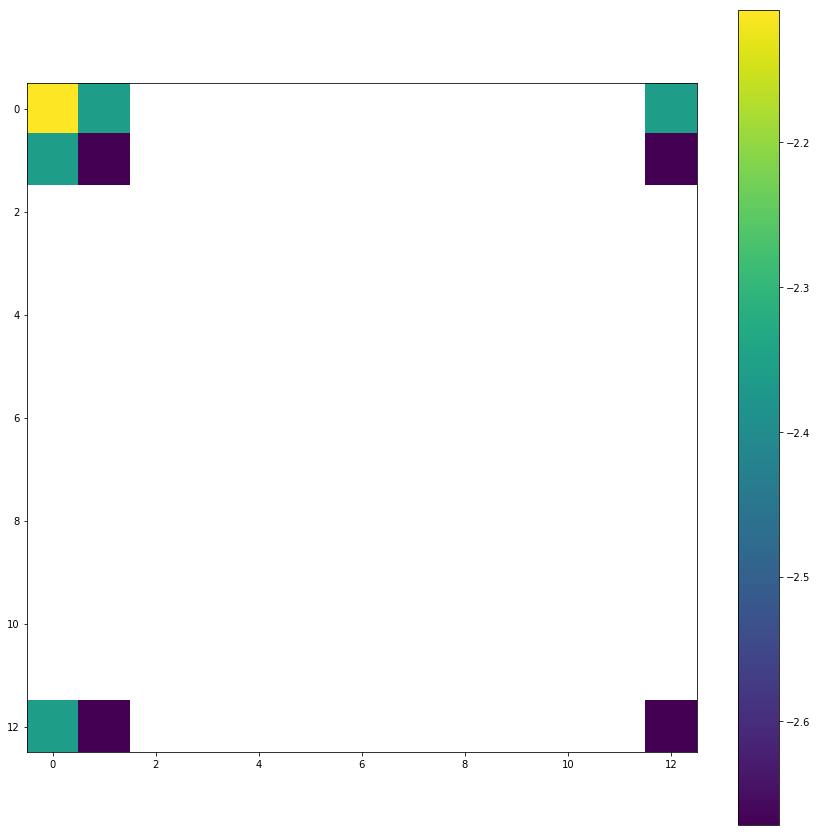

In [110]:
plt.figure(figsize=(15,15))
plt.imshow(np.log(beta_approx))
plt.colorbar()
plt.show()

In [59]:
beta_approx_fn = lambda kx, ky: np.median([image_fourier_sections_magnitude[i][kx,ky] / imbar_sections[i] for i in range(len(image_sections))])
beta_approx = np.zeros_like(image_sections[0])
for kx in range(beta_approx.shape[0]):
    for ky in range(beta_approx.shape[1]):
        beta_approx[kx,ky] = beta_approx_fn(kx, ky)

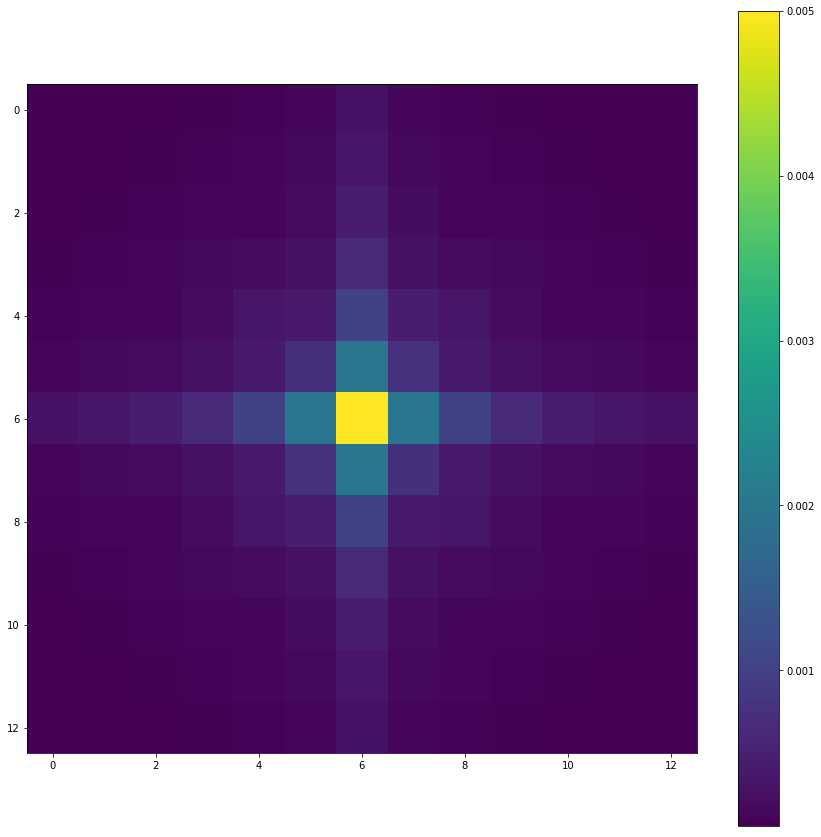

In [67]:
plt.figure(figsize=(15,15))
plt.imshow(beta_approx, vmax=0.0050)
plt.colorbar()
plt.show()

In [111]:
noise_sections = [beta_approx * imbar_sections[i] for i in range(len(image_sections))]
threshold = [3 * noise_section for noise_section in noise_sections]

gate_filter = np.logical_not([image_fourier_sections_magnitude[i] < threshold[i] for i in range(len(image_sections))])
#wiener_filter =  [(image_fourier_sections_magnitude[i]  / threshold[i]) / (1 + (image_fourier_sections_magnitude[i]  / threshold[i])) for i in range(len(image_sections))]

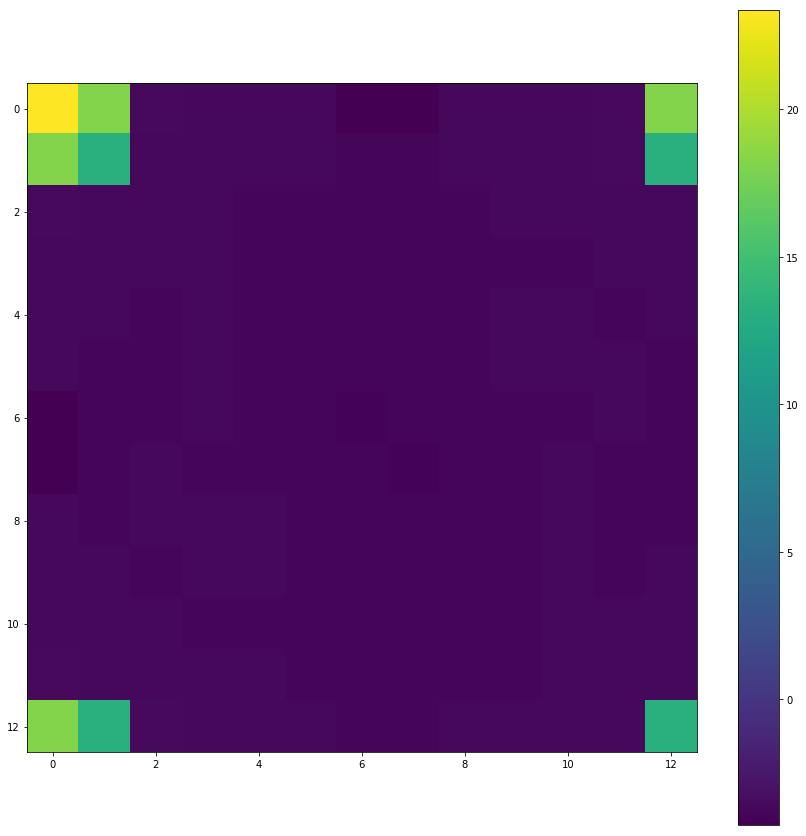

In [112]:
plt.figure(figsize=(15,15))
plt.imshow(threshold[i])
plt.colorbar()
plt.show()

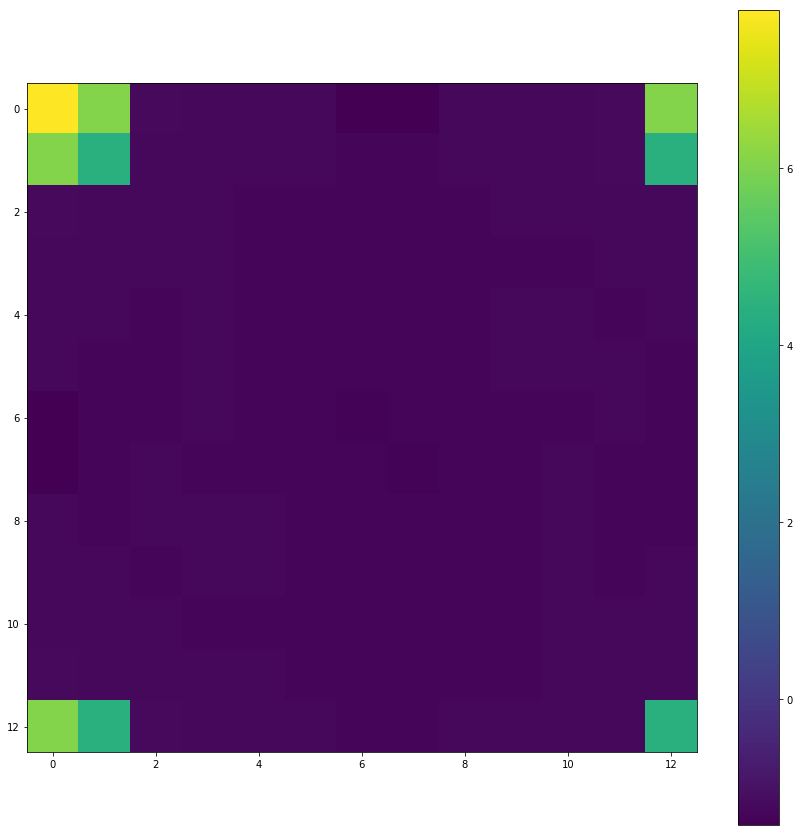

In [113]:
plt.figure(figsize=(15,15))
plt.imshow(noise_sections[i])
plt.colorbar()
plt.show()

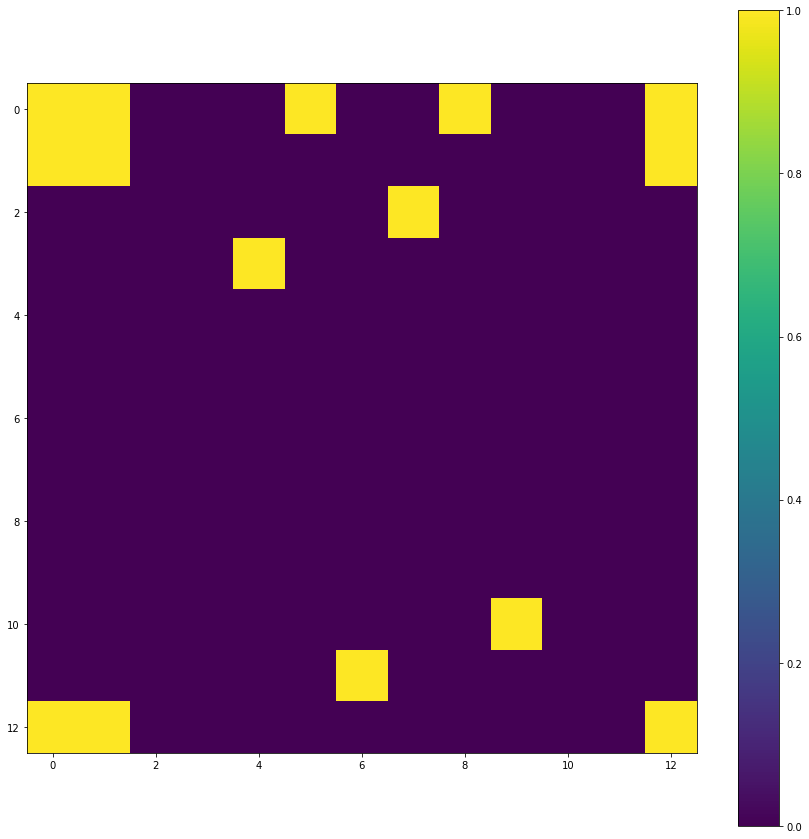

In [114]:
plt.figure(figsize=(15,15))
plt.imshow(image_fourier_sections_magnitude[i] < threshold[i])
plt.colorbar()
plt.show()

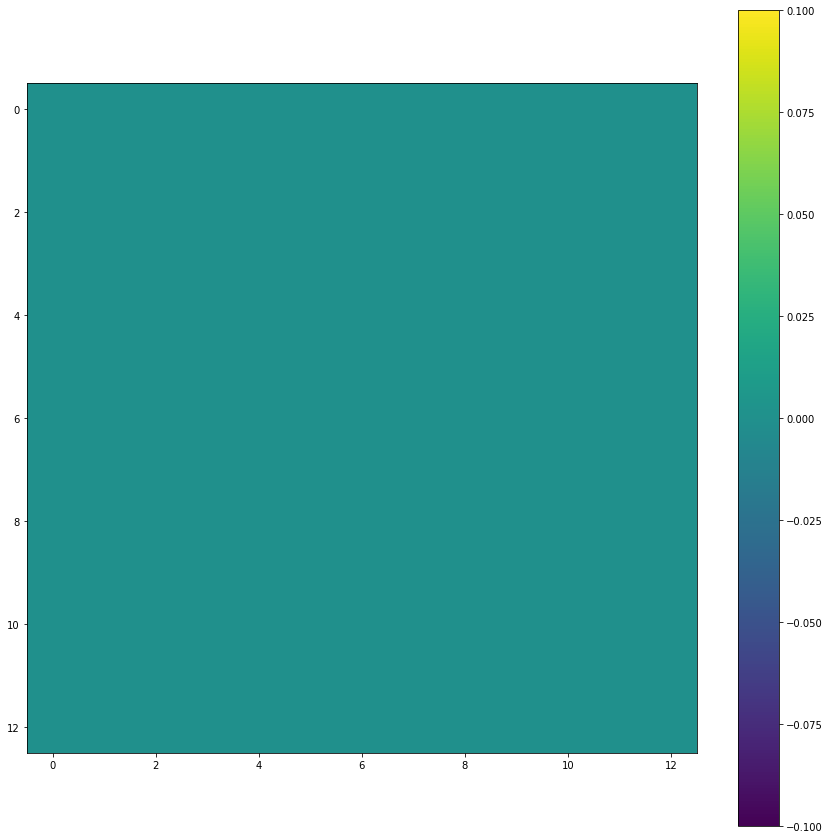

In [39]:
plt.figure(figsize=(15,15))
plt.imshow(gate_filter[i])
plt.colorbar()
plt.show()

In [115]:
final_fourier_sections = [image_fourier_sections[i] * gate_filter[i] for i in range(len(image_sections))]

new_image = np.zeros_like(data)
for i in range(len(coords)):
    x, y = coords[i]
    new_image[x-xwidth : x+xwidth + 1,
              y-ywidth : y+ywidth + 1] += hanning * np.abs(ifft((final_fourier_sections[i])))

#f, axarr = plt.subplots(2)
#axarr[0].imshow(new_image)
#axarr[1].imshow(data)
#plt.show()

#image_file[0].data = new_image
#image_file.writeto(outfile)

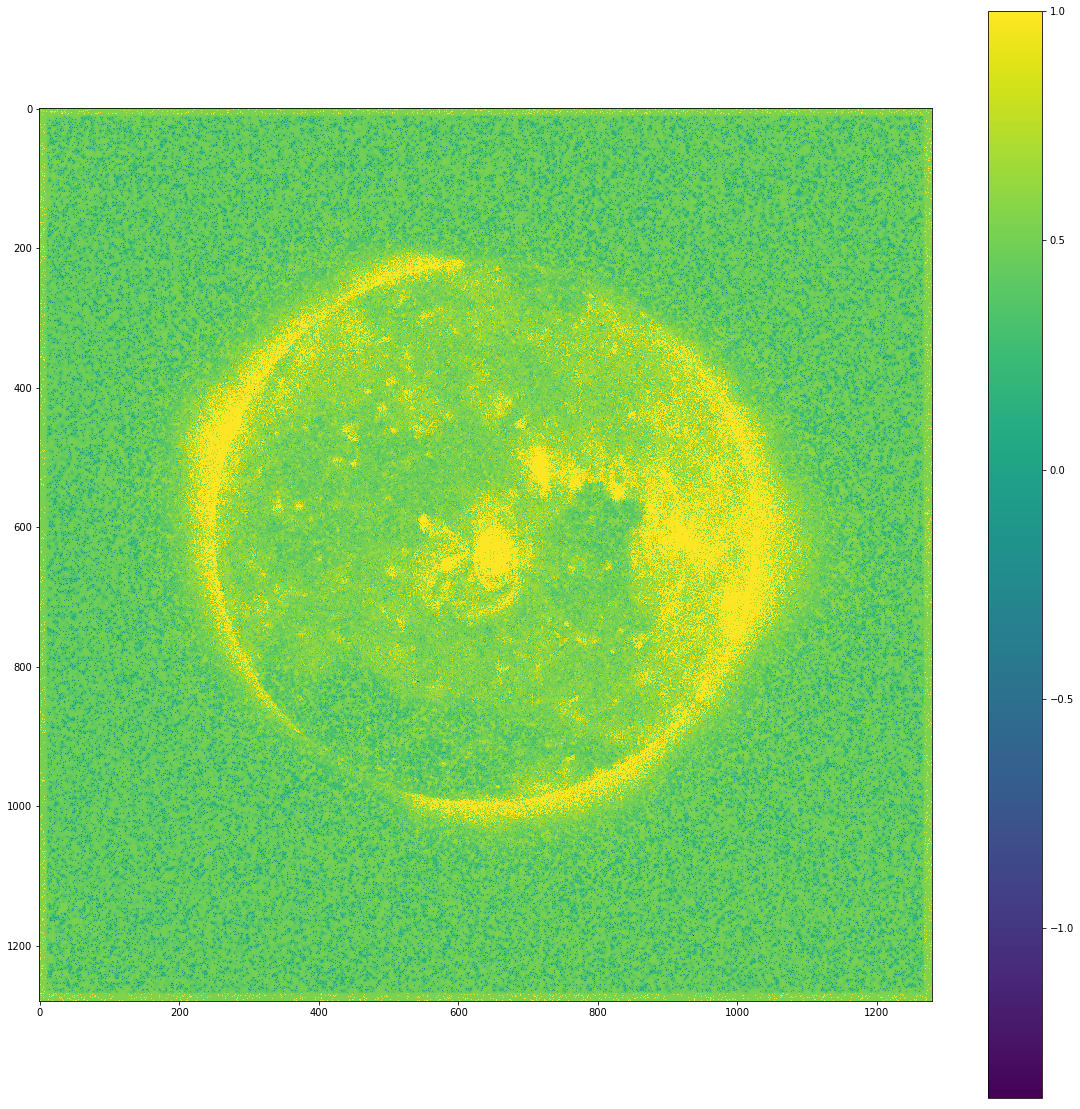

In [120]:
plt.figure(figsize=(20,20))
plt.imshow(data - new_image, vmax=1)
plt.colorbar()
plt.show()

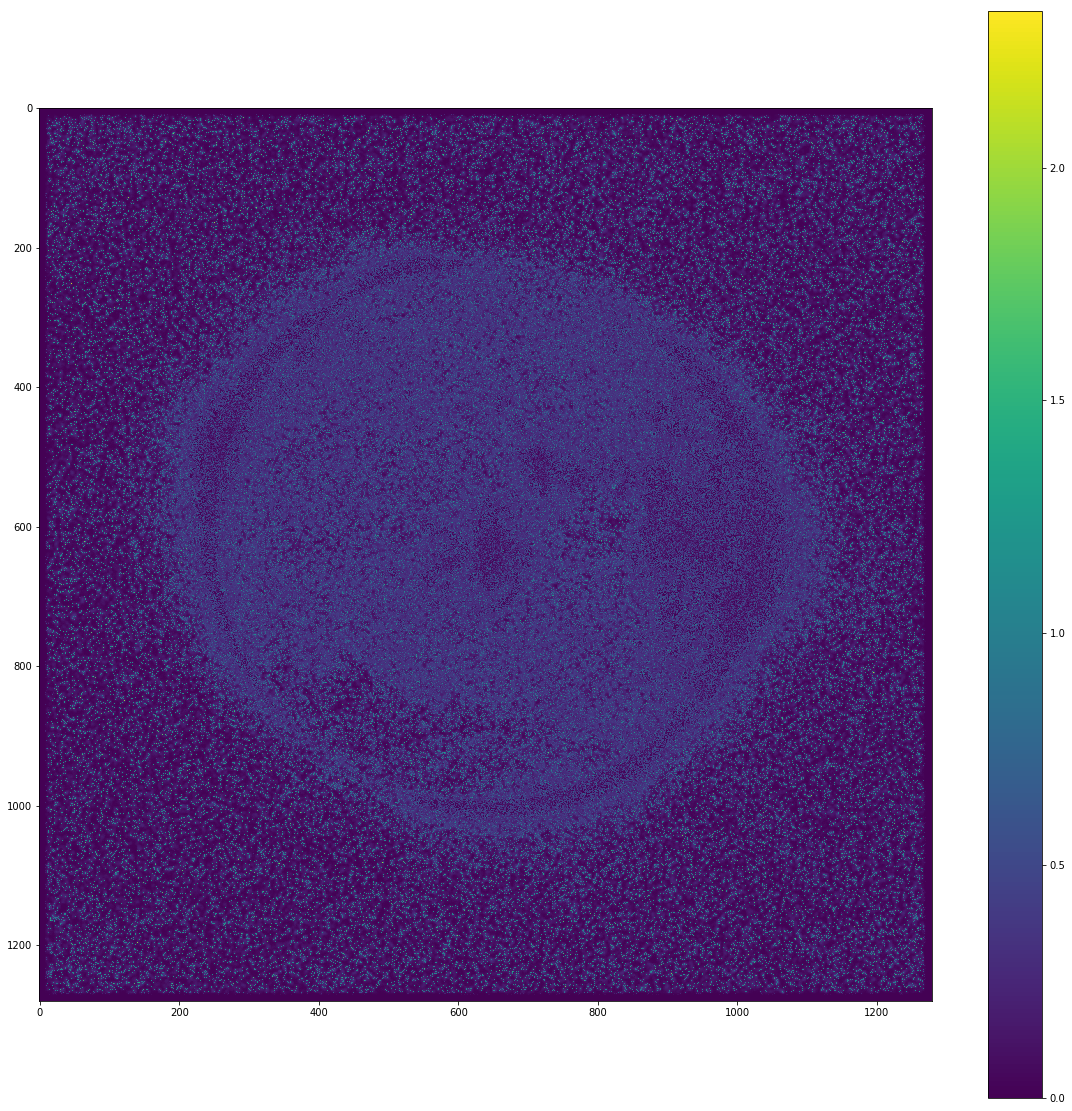

In [118]:
plt.figure(figsize=(20,20))
plt.imshow(new_image)
plt.colorbar()
plt.show()

In [56]:
image_file[0].data = new_image
image_file.writeto("/Users/mhughes/Desktop/noisy_gate_gamma1.fits")

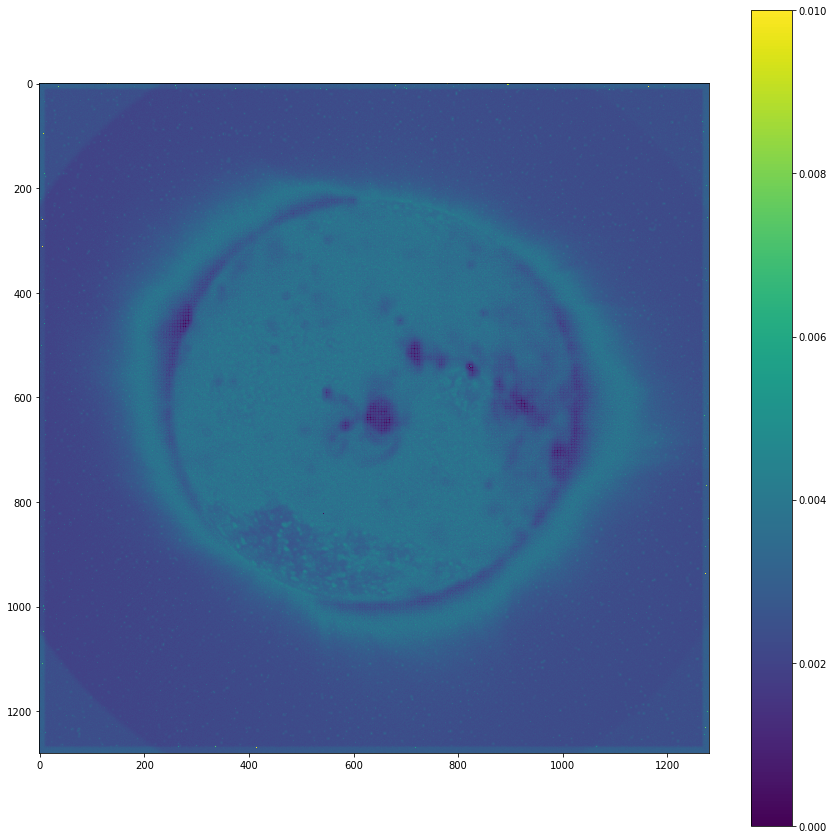

In [117]:
plt.figure(figsize=(15,15))
plt.imshow(np.abs((new_image / np.max(new_image)) - (data / np.max(data))), vmax=0.01)
plt.colorbar()
plt.show()

In [ ]:
image_file[0].data = new_image - data
image_file.writeto("/Users/mhughes/Desktop/wiener12_r.fits")

In [ ]:
region_image = np.zeros_like(data)
for i in range(len(coords)):
    x, y = coords[i]
    region_image[x-xwidth : x+xwidth + 1,
              y-ywidth : y+ywidth + 1] += hanning

#f, axarr = plt.subplots(2)
#axarr[0].imshow(new_image)
#axarr[1].imshow(data)
#plt.show()

#image_file[0].data = new_image
#image_file.writeto(outfile)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(region_image)
plt.colorbar()
plt.show()

In [49]:
noisy_image = data.copy()
for i in range(1):
    noise = np.random.poisson(lam=data, size=None)
    noisy_image += noise

0


In [56]:
noise = np.random.poisson(lam=data, size=None)

In [57]:
np.max(noise)

75

In [149]:
image_file[0].data = noisy_image
image_file.writeto("/Users/mhughes/Desktop/noisy.fits")